# Growth Mechanism with Details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [3]:
para_path = './Datasets/J14_PM11_12_14_17_gaussian_fit_parameters.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='J14')
ds_para.data_info

Growth: temp350:
--spot: spot_1:
----height:, Size of data: (250730,)
----img_max:, Size of data: (250730,)
----img_mean:, Size of data: (250730,)
----img_rec_max:, Size of data: (250730,)
----img_rec_mean:, Size of data: (250730,)
----img_rec_sum:, Size of data: (250730,)
----img_sum:, Size of data: (250730,)
----raw_image:, Size of data: (250730, 22, 15)
----reconstructed_image:, Size of data: (250730, 22, 15)
----width_x:, Size of data: (250730,)
----width_y:, Size of data: (250730,)
----x:, Size of data: (250730,)
----y:, Size of data: (250730,)
--spot: spot_2:
----height:, Size of data: (250730,)
----img_max:, Size of data: (250730,)
----img_mean:, Size of data: (250730,)
----img_rec_max:, Size of data: (250730,)
----img_rec_mean:, Size of data: (250730,)
----img_rec_sum:, Size of data: (250730,)
----img_sum:, Size of data: (250730,)
----raw_image:, Size of data: (250730, 55, 22)
----reconstructed_image:, Size of data: (250730, 55, 22)
----width_x:, Size of data: (250730,)
----wid

## 2. Analyze the Decay Curve

temp500


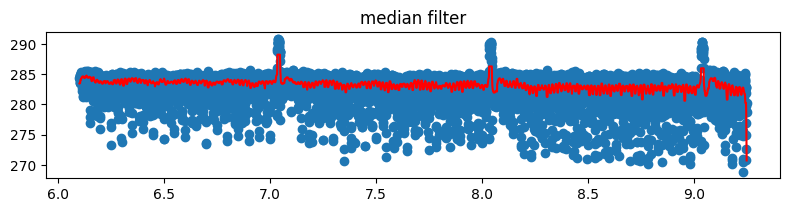

temp550


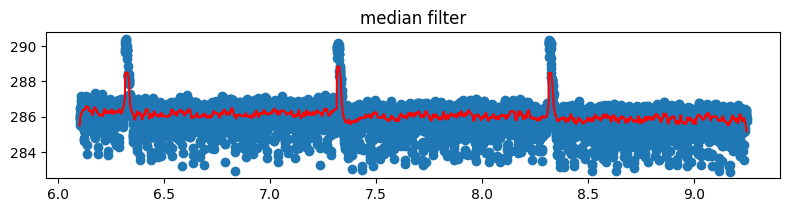

In [3]:
for temp in ['temp500', 'temp550']:
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    sample_x, sample_y = sample_x[12200:18500], sample_y[12200:18500]
    print(temp)
#     data = np.stack([sample_x, sample_y], 1)
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

('img_rec_sum', 'spot_2')


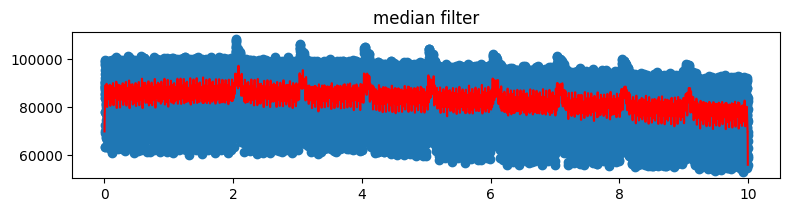

('img_rec_max', 'spot_2')


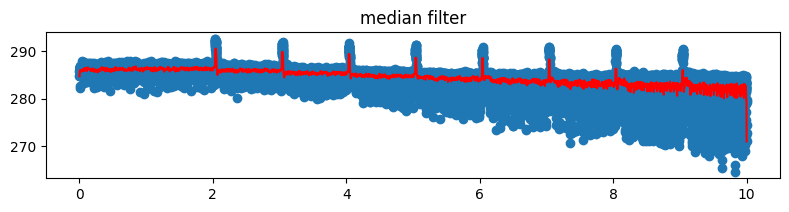

('height', 'spot_2')


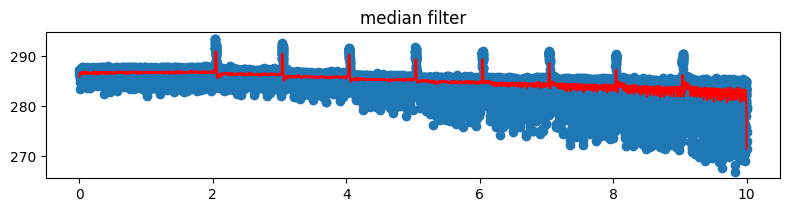

('x', 'spot_1')


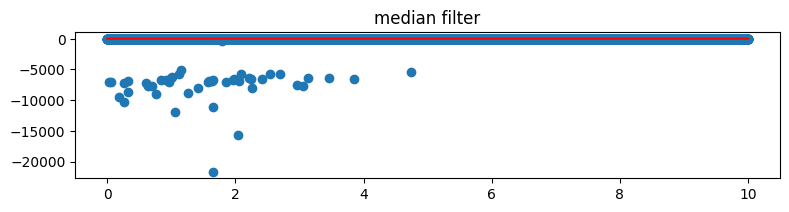

In [4]:
ranges_list = [(0, 20), (0, 20), (0, 20), (0, 20)]
m_spot_list = [("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp500', spot=spot, metric=m, x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, 0, 10)
    sample_x, sample_y = data[:, 0], data[:, 1]
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

In [1]:
import numpy as np
print(np.__version__)

1.23.4


temp500


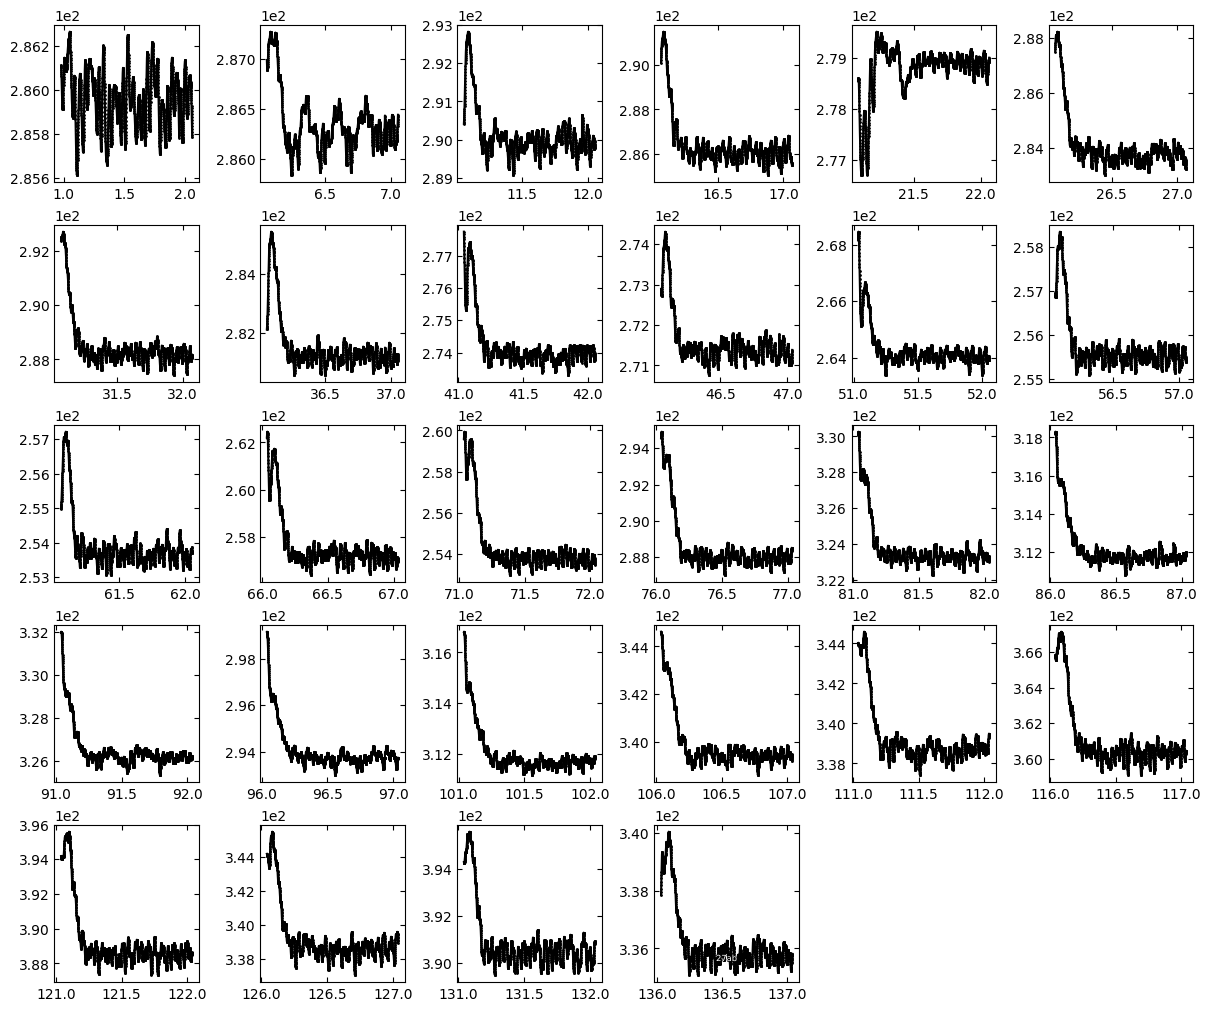

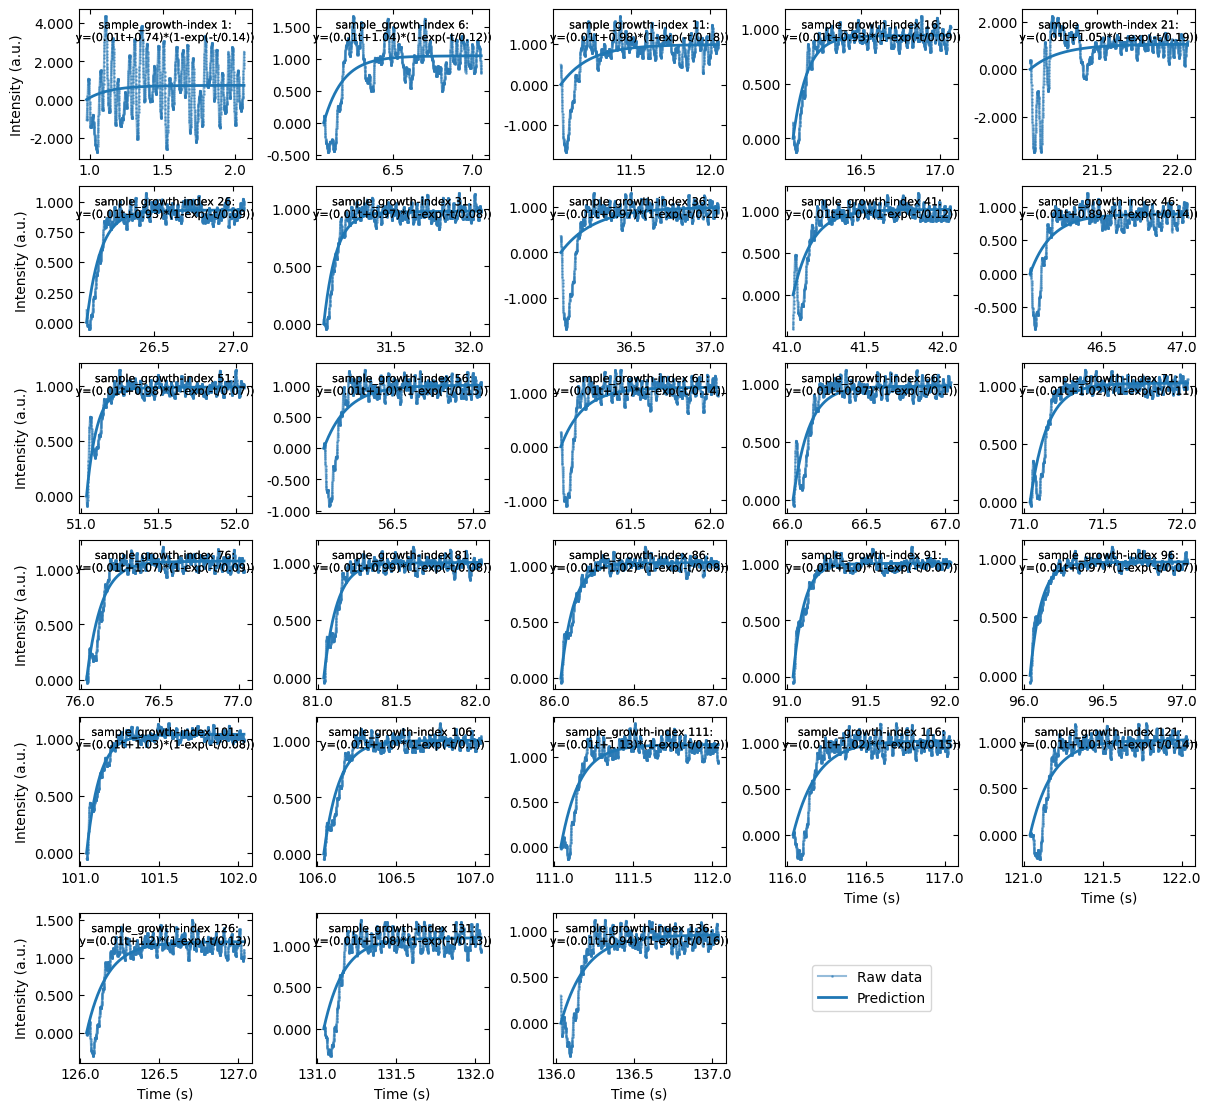

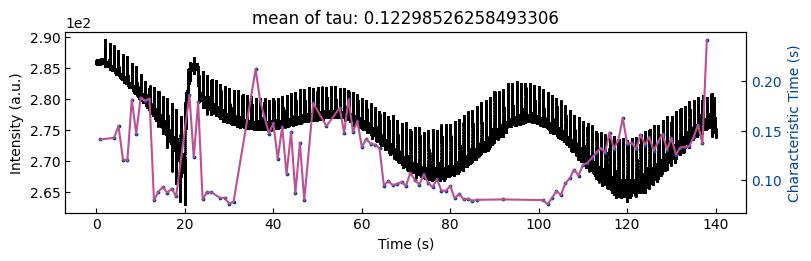

temp550


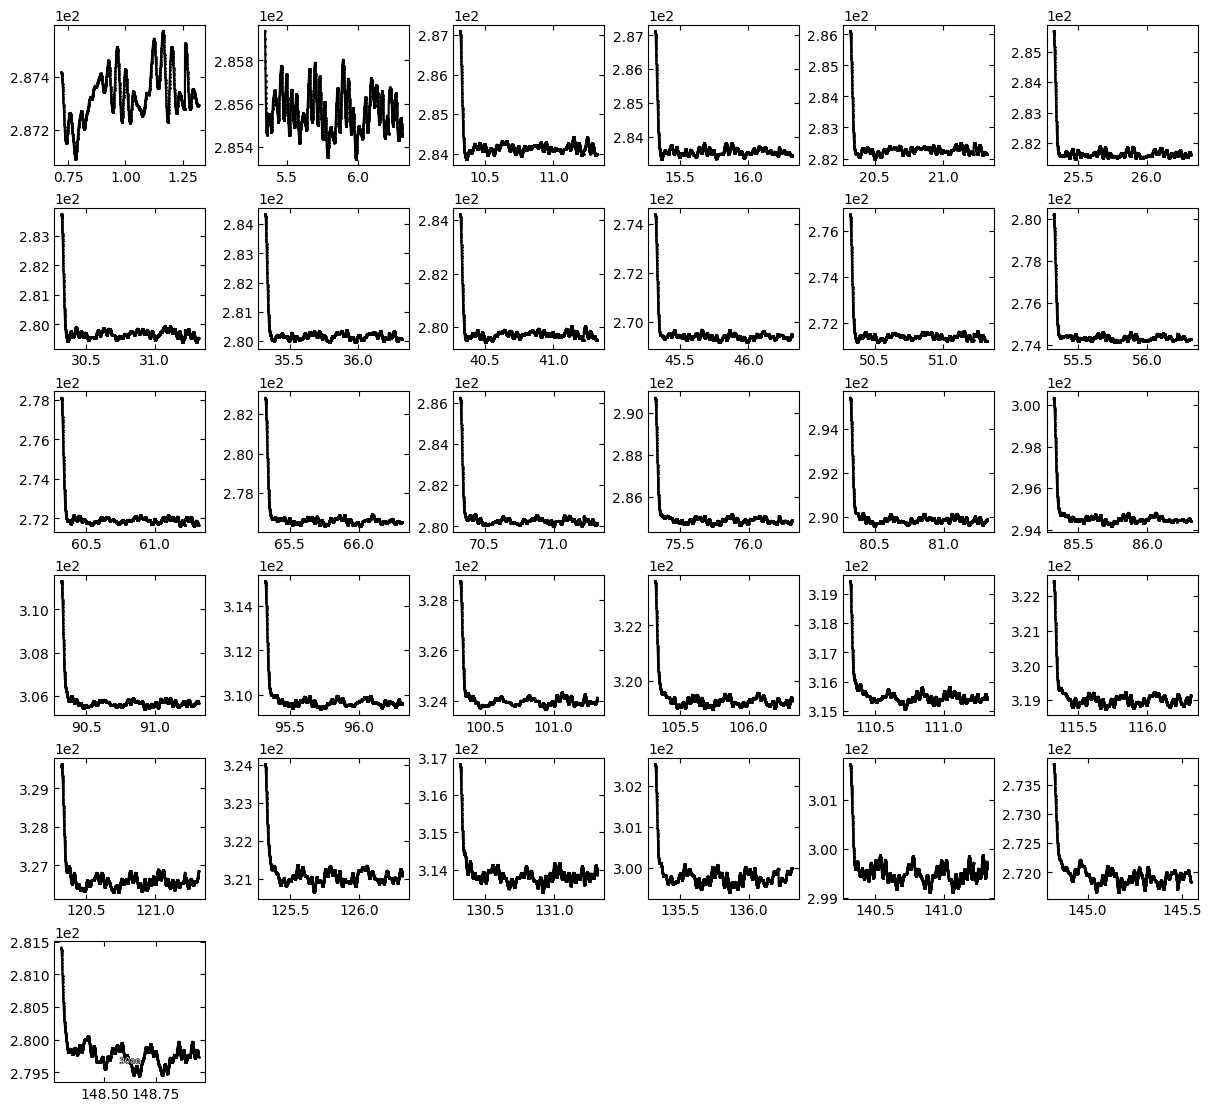

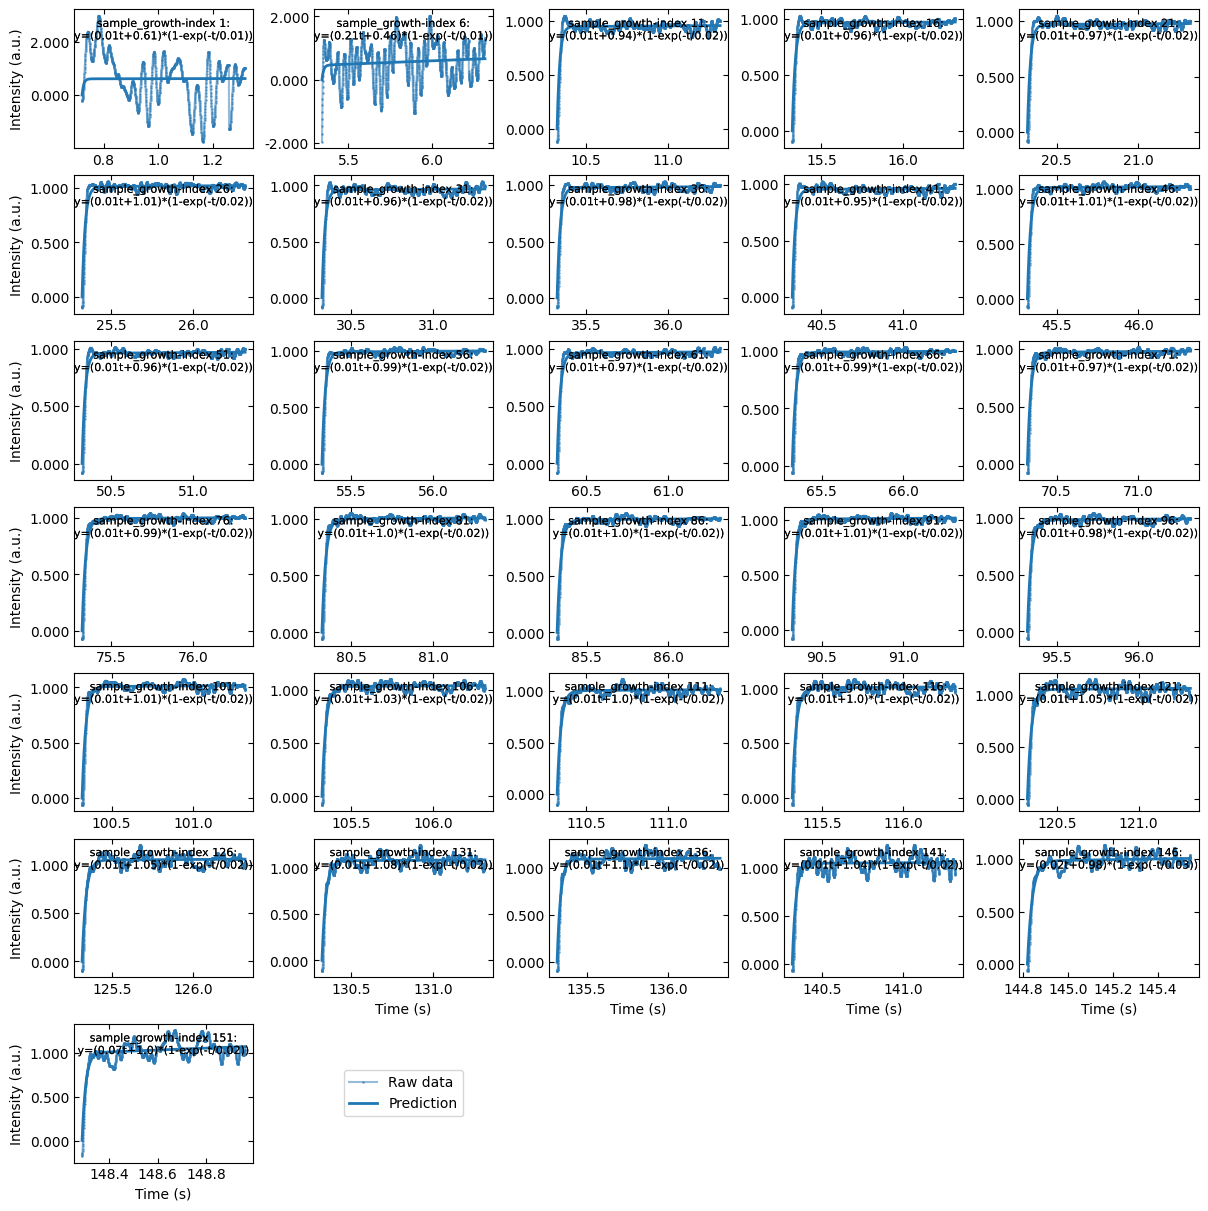

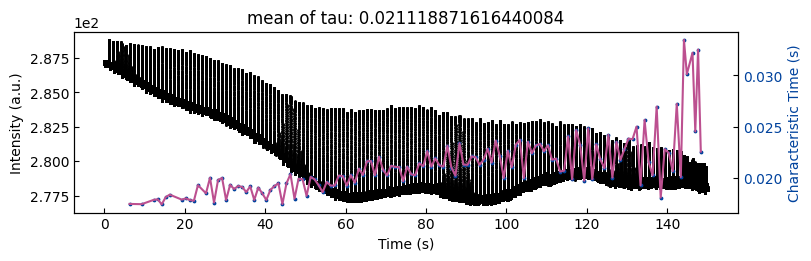

In [7]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 2], 'p_init':(1, 0.1, 0.1), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 140), (0, 150)]
temp_list = ['temp500', 'temp550']

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)

temp500


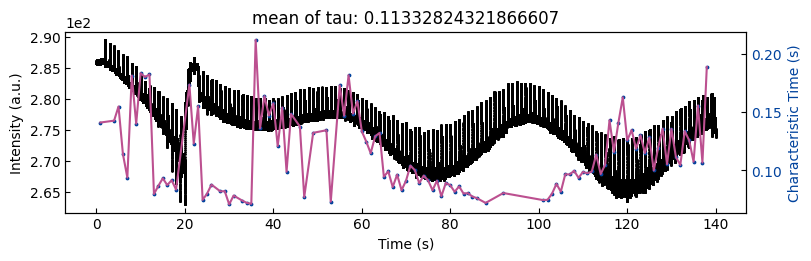

temp550


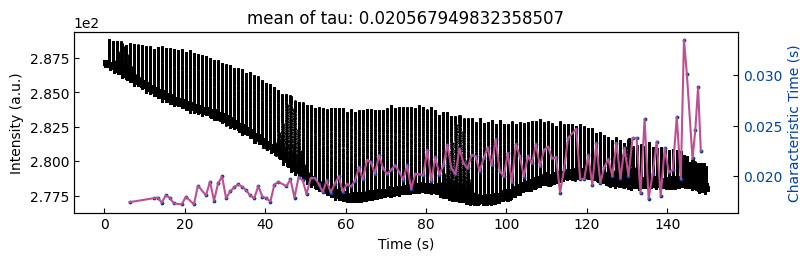

In [8]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 140), (0, 150)]
temp_list = ['temp500', 'temp550']

T_list, tau_list = [500, 550], []
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    tau_list.append(tau)

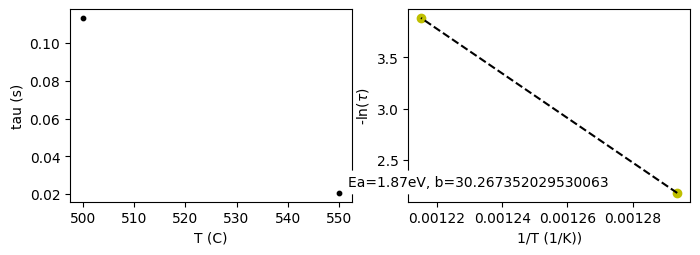

In [9]:
plot_activation_energy(T_list, tau_list)

In [14]:
np.save('./Saved_data/tau_PM08_500C.npy', tau_list[0])

In [15]:
np.save('./Saved_data/tau_PM08_550C.npy', tau_list[1])

In [12]:
tau_list

[array([0.14101653, 0.14262807, 0.15474118, 0.11391187, 0.09385698,
        0.18116942, 0.14002029, 0.18327105, 0.18003403, 0.18215449,
        0.07979757, 0.08682744, 0.09326085, 0.08745134, 0.09156781,
        0.08361418, 0.17346388, 0.12300391, 0.15492567, 0.07482807,
        0.08004264, 0.08785287, 0.0820799 , 0.08221846, 0.07093984,
        0.07847906, 0.07405514, 0.07216889, 0.0714743 , 0.21178301,
        0.13608198, 0.16358754, 0.14698051, 0.15741969, 0.12089604,
        0.15387398, 0.098926  , 0.14833311, 0.13759743, 0.07718456,
        0.13219983, 0.13440922, 0.07322925, 0.17280578, 0.14679563,
        0.18152783, 0.14865584, 0.15929777, 0.13339965, 0.1247006 ,
        0.11475889, 0.12913229, 0.13210426, 0.09464783, 0.09920913,
        0.08583692, 0.09631497, 0.08309671, 0.0910908 , 0.10412926,
        0.10023744, 0.08905576, 0.09553519, 0.09140654, 0.08303243,
        0.0912432 , 0.07786355, 0.08928173, 0.08730255, 0.08172019,
        0.08632129, 0.08021983, 0.08053512, 0.07